In [107]:
educacion = pd.read_csv("../datos reales/años_esperados_educación.csv")
educacion = educacion[educacion["Disaggregation"]=="total"]
educacion = educacion.drop(["Indicator Name","Indicator Code", "Country Name", "Disaggregation"], axis=1).pivot(index="Country Code",columns="Year", values="Value")

In [147]:
educacion.reset_index()

,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFE,4.799,4.808,4.892,4.915,5.125,5.333,5.462,5.561,5.681,...,9.509,9.417,9.464,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,2.579,2.706,2.798,2.866,3.004,2.998,3.113,3.218,3.351,...,10.465,NaN,NaN,NaN,10.538,NaN,NaN,NaN,NaN,NaN
3,AFW,3.290,3.372,3.532,3.647,3.693,3.746,3.823,4.206,4.782,...,8.874,8.892,8.698,8.701,8.709,NaN,NaN,NaN,NaN,NaN
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,WSM,8.820,NaN,NaN,9.176,NaN,10.208,NaN,10.456,10.535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,ZAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.282,14.606,14.245,14.265,14.081,14.214,13.983,14.114,NaN,NaN
250,ZMB,6.600,NaN,NaN,NaN,7.116,7.086,7.315,7.303,7.294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
educacion[1970]

Country Code
ABW      NaN
AFE    4.799
AFG    2.579
AFW    3.290
AGO      NaN
       ...  
WSM    8.820
YEM      NaN
ZAF      NaN
ZMB    6.600
ZWE      NaN
Name: 1970, Length: 252, dtype: float64

In [144]:
percentiles_ingresos["year"].astype(str)

0         2000
1         2000
2         2000
3         2000
4         2000
          ... 
245587    2019
245588    2019
245589    2019
245590    2019
245591    2019
Name: year, Length: 245592, dtype: object

In [167]:
datos = pd.read_csv("../datos reales/suscripciones_celular_cada_100.csv")
datos

,Series Name,Series Code,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,Argentina,ARG,0,..,..,..,..,0,...,142.9902363,142.9639551,145.9179567,140.5014607,131.9371685,125.9409814,121.6001889,130.4550081,132.3578095,..
1,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,Australia,AUS,0,..,..,..,..,0,...,106.7765212,108.1853261,109.7343698,108.4165835,110.6519296,110.29622,105.231579,104.5172138,107.0312028,..
2,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,Brazil,BRA,0,..,..,..,..,0,...,137.9776265,125.6477067,117.9869738,106.1217992,99.64002652,95.38505233,96.54706819,102.48887,98.89102076,..
3,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,China,CHN,0,..,..,..,..,0,...,92.84598562,92.70071605,97.36386675,104.2265872,116.3882038,122.8132903,120.5961882,121.5382526,124.8775379,..
4,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,France,FRA,0,..,..,..,..,0,...,102.8881154,104.4996731,105.5973124,107.5983841,109.5588076,111.8637727,112.8271405,116.6934991,118.8472962,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


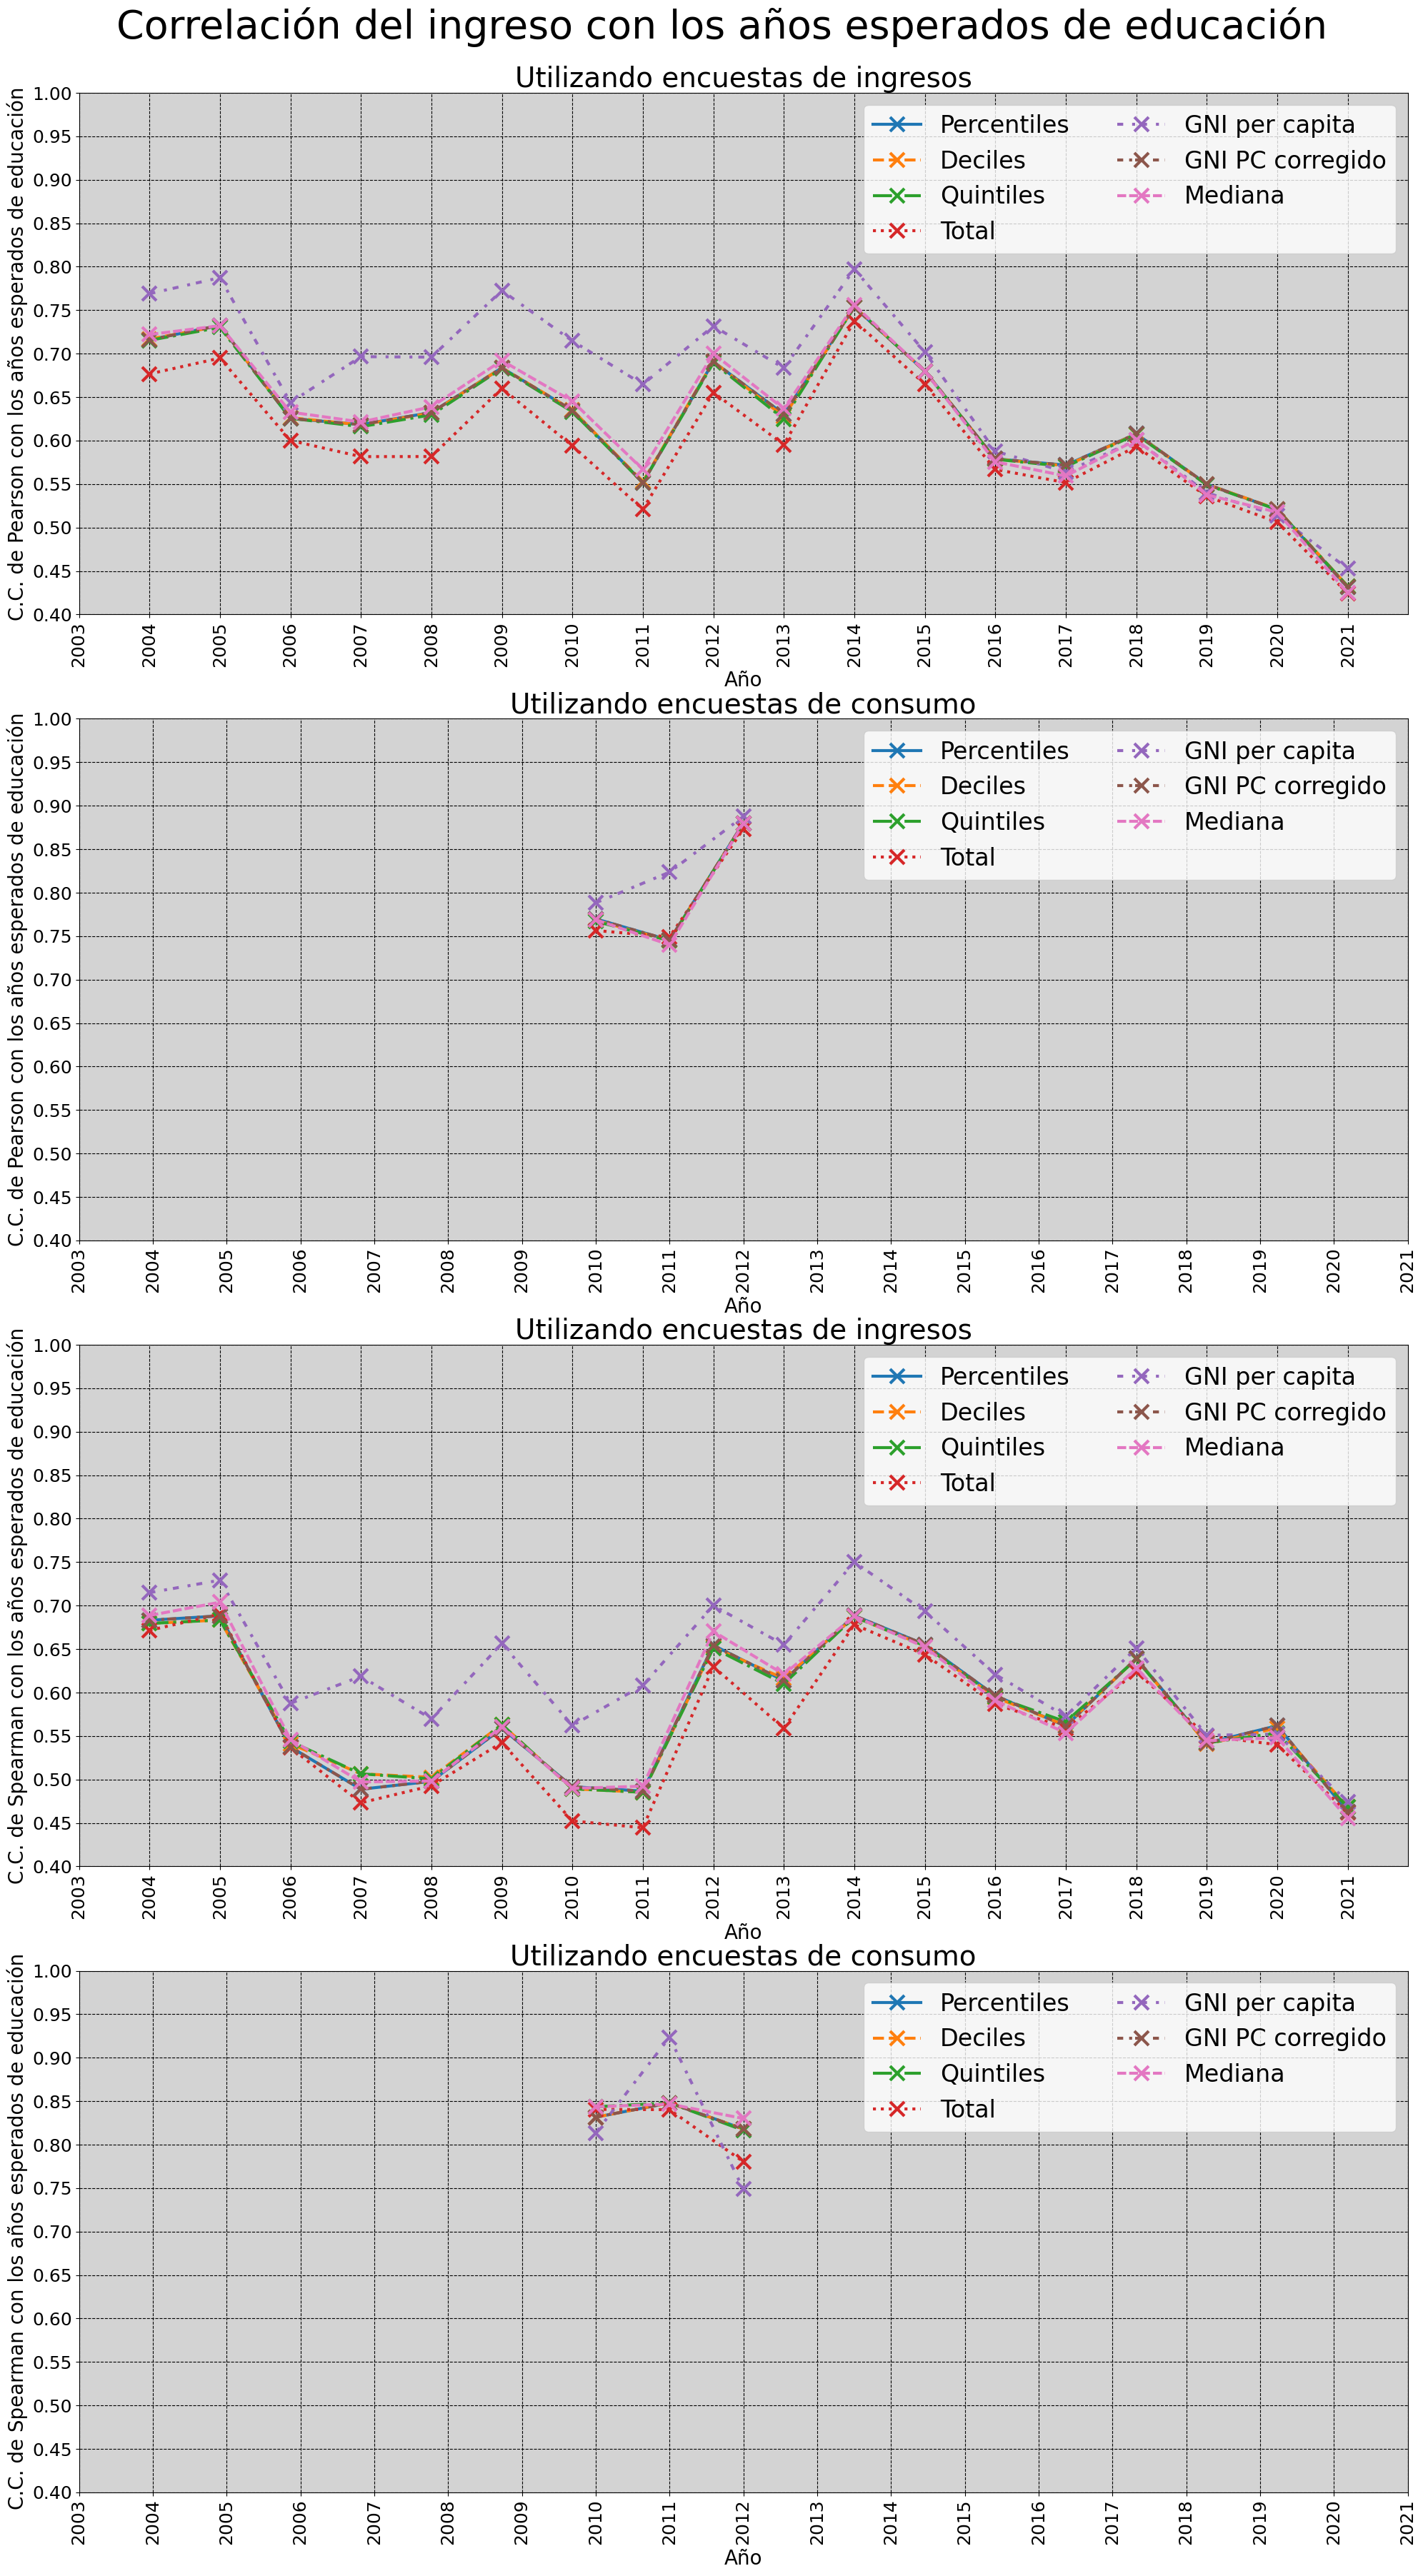

In [164]:
# from general import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

def Cambiar(s : str):
    if s[-1]==']': return s[:4]
    return s

datos = pd.read_csv("../datos reales/suscripcion_celular_cada_100.csv")
datos.columns = list(map(Cambiar, datos.columns))
datos[datos=='..'] = pd.NA

gni_ppa = pd.read_csv("../datos reales/gni_ppa_2021_per_capita.csv")
gni_ppa.columns = list(map(Cambiar, gni_ppa.columns))
gni_ppa[gni_ppa=='..'] = pd.NA

percentiles_ingresos = pd.read_csv("../datos reales/percentiles_ingresos_PPA_2011.csv")
percentiles_ingresos["year"] = percentiles_ingresos["year"].astype(str)


def Sintetizador(tam = 100):
    def Sintesis(ingresos):
        sintesis = 0
        for ini in range(0,100,tam):
            rango = ingresos.iloc[ini:(ini+tam)]
            peso = np.sum(rango['pop_share'])
            avg_rango = np.sum(rango['avg_welfare'] * rango['pop_share'])/peso
            sintesis += np.log(avg_rango)*peso
        return sintesis
    return Sintesis

def GenerarMuestra(datos_originales, umbral):
    muestras = dict()
    years = set(datos_originales["year"]).intersection(educacion.columns)
    for year in sorted(years):
        #try:
            datos_anio = datos_originales[datos_originales['year']==year]
            paises = datos_anio['country_code'].unique()
            
            paises = list(filter(lambda x : 
                sum(datos_anio['country_code']==x)==100, paises
            ))
            edu = educacion[~ educacion[str(year)].isna()]
            paises = set(paises).intersection(edu['Country Code'].unique())
            paises = list(paises) 

            gni = gni_ppa[~gni_ppa[str(year)].isna()]
            paises = set(paises).intersection(gni['Country Code'].unique())
            paises = list(paises) 
        
            if len(paises) < umbral: continue
            
            grupos_in = datos_anio.groupby('country_code')
            
            muestras[year] = []
            
            edu.set_index('Country Code', inplace=True)
            gni.set_index('Country Code', inplace=True)

            for country in paises:
                tams = (1,10,20,100)
                muestra = []
                for (i,tam) in enumerate(tams):
                    muestra.append(Sintetizador(tam)(grupos_in.get_group(country)))
                muestra.append(np.log(float(gni.loc[country][str(year)])))
                
                A = np.exp(muestra[0]-muestra[-1])
                muestra.append(np.log(float(gni.loc[country][str(year)]) * A))

                muestra.append(np.log(np.quantile(grupos_in.get_group(country)['avg_welfare'], q=0.5)))
                muestras[year].append((country,muestra, edu.loc[country][str(year)]))
        #except Exception as e:
        #    print(e.with_traceback()) 
        #    pass 
    return muestras

percentiles_ingresos_ni = percentiles_ingresos[
    np.array(percentiles_ingresos['welfare_type']=='income') &
    np.array(percentiles_ingresos['reporting_level']=='national')
]

percentiles_ingresos_comp = percentiles_ingresos[
    np.array(percentiles_ingresos['welfare_type']=='consumption') &
    np.array(percentiles_ingresos['reporting_level']=='national')
]

muestras_ingreso = GenerarMuestra(percentiles_ingresos_ni,20)
muestras_consumo = GenerarMuestra(percentiles_ingresos_comp,20)

# print(muestras_ingreso)

fig, axs = plt.subplots(4,1, figsize=(24,40))
fig.subplots_adjust(top=0.95) 
fig.suptitle('Correlación del ingreso con los años esperados de educación', fontsize=40)

muestras = [muestras_ingreso, muestras_consumo]
nombres_m = ["ingresos","consumo"]
nombres =  ["Percentiles","Deciles","Quintiles","Total", "GNI per capita", "GNI PC corregido", "Mediana"]
estilos =  ['-','--','-.',':', (0,(2,3,1,2)), (0,(2,2,1,1,3,3)), (0,(3,1))]

xticks = list(range(2003,2022))
xlabel_ticks = list(map(str, xticks))

yticks_mayor = np.linspace(0.40,1,13)
yticks_menor = np.linspace(0.40,1,25)

def GenerarSeries(muestras, metrica):
    xs = list(sorted(muestras.keys()))
    ys = []
    for x in xs:
        muestra = muestras[x]
        series = []
        for i in range(len(muestra[0][1])):
            a = [float(item[1][i]) for item in muestra]
            b = [float(item[2]) for item in muestra]
            series.append(metrica(a,b))
        ys.append(tuple(series))
    xs = list(map(int,xs))
    return xs,ys

correlaciones = [
    ("C.C. de Pearson", pearsonr),
    ("C.C. de Spearman", spearmanr)
]

#for (ax,muestra,nombre_muestra) in zip(axs,muestras,nombres_m):
for axi in range(len(axs)):
    ax = axs[axi]
    muestra = muestras[axi%2]
    nombre_muestra = nombres_m[axi%2]

    correlacion = correlaciones[axi//2][1]
    correlacion_nombre = correlaciones[axi//2][0]

    xs, ys = GenerarSeries(muestra, lambda x,y : correlacion(x,y).correlation)
    for (i, nombre, estilo) in zip(range(len(nombres)),nombres,estilos):
        ax.plot(xs,[y[i] for y in ys], label = nombre, linestyle=estilo, marker='x', linewidth=3, markersize = 15, markeredgewidth=3)
    
    ax.set_ylabel(f"{correlacion_nombre} con los años esperados de educación", fontsize=20)
    ax.set_xlabel("Año", fontsize=20)
    ax.set_title(f"Utilizando encuestas de {nombre_muestra}", fontsize = 28)
    ax.set_xticks(ticks = xticks, labels= xlabel_ticks, rotation=90, fontsize=18)
    # ax.set_xticks(ticks = xticks, labels=[None]*len(xticks))
    ax.set_yticks(ticks = yticks_mayor, minor=False, labels=list(map(lambda x: f"{x:.2f}", yticks_mayor)), fontsize=18)
    # ax.set_yticks(ticks = yticks_menor, labels=("" for _ in yticks_menor), linestyle=(0,(2,1)), minor=True)
    ax.grid(c='black', linestyle='--')
    ax.set_facecolor('lightgray')
    ax.legend(fontsize=24, ncols=2)


# fig.savefig("../figuras/figura_19_empirico_todas_metricas_vs_evn_pearson.png",bbox_inches='tight')

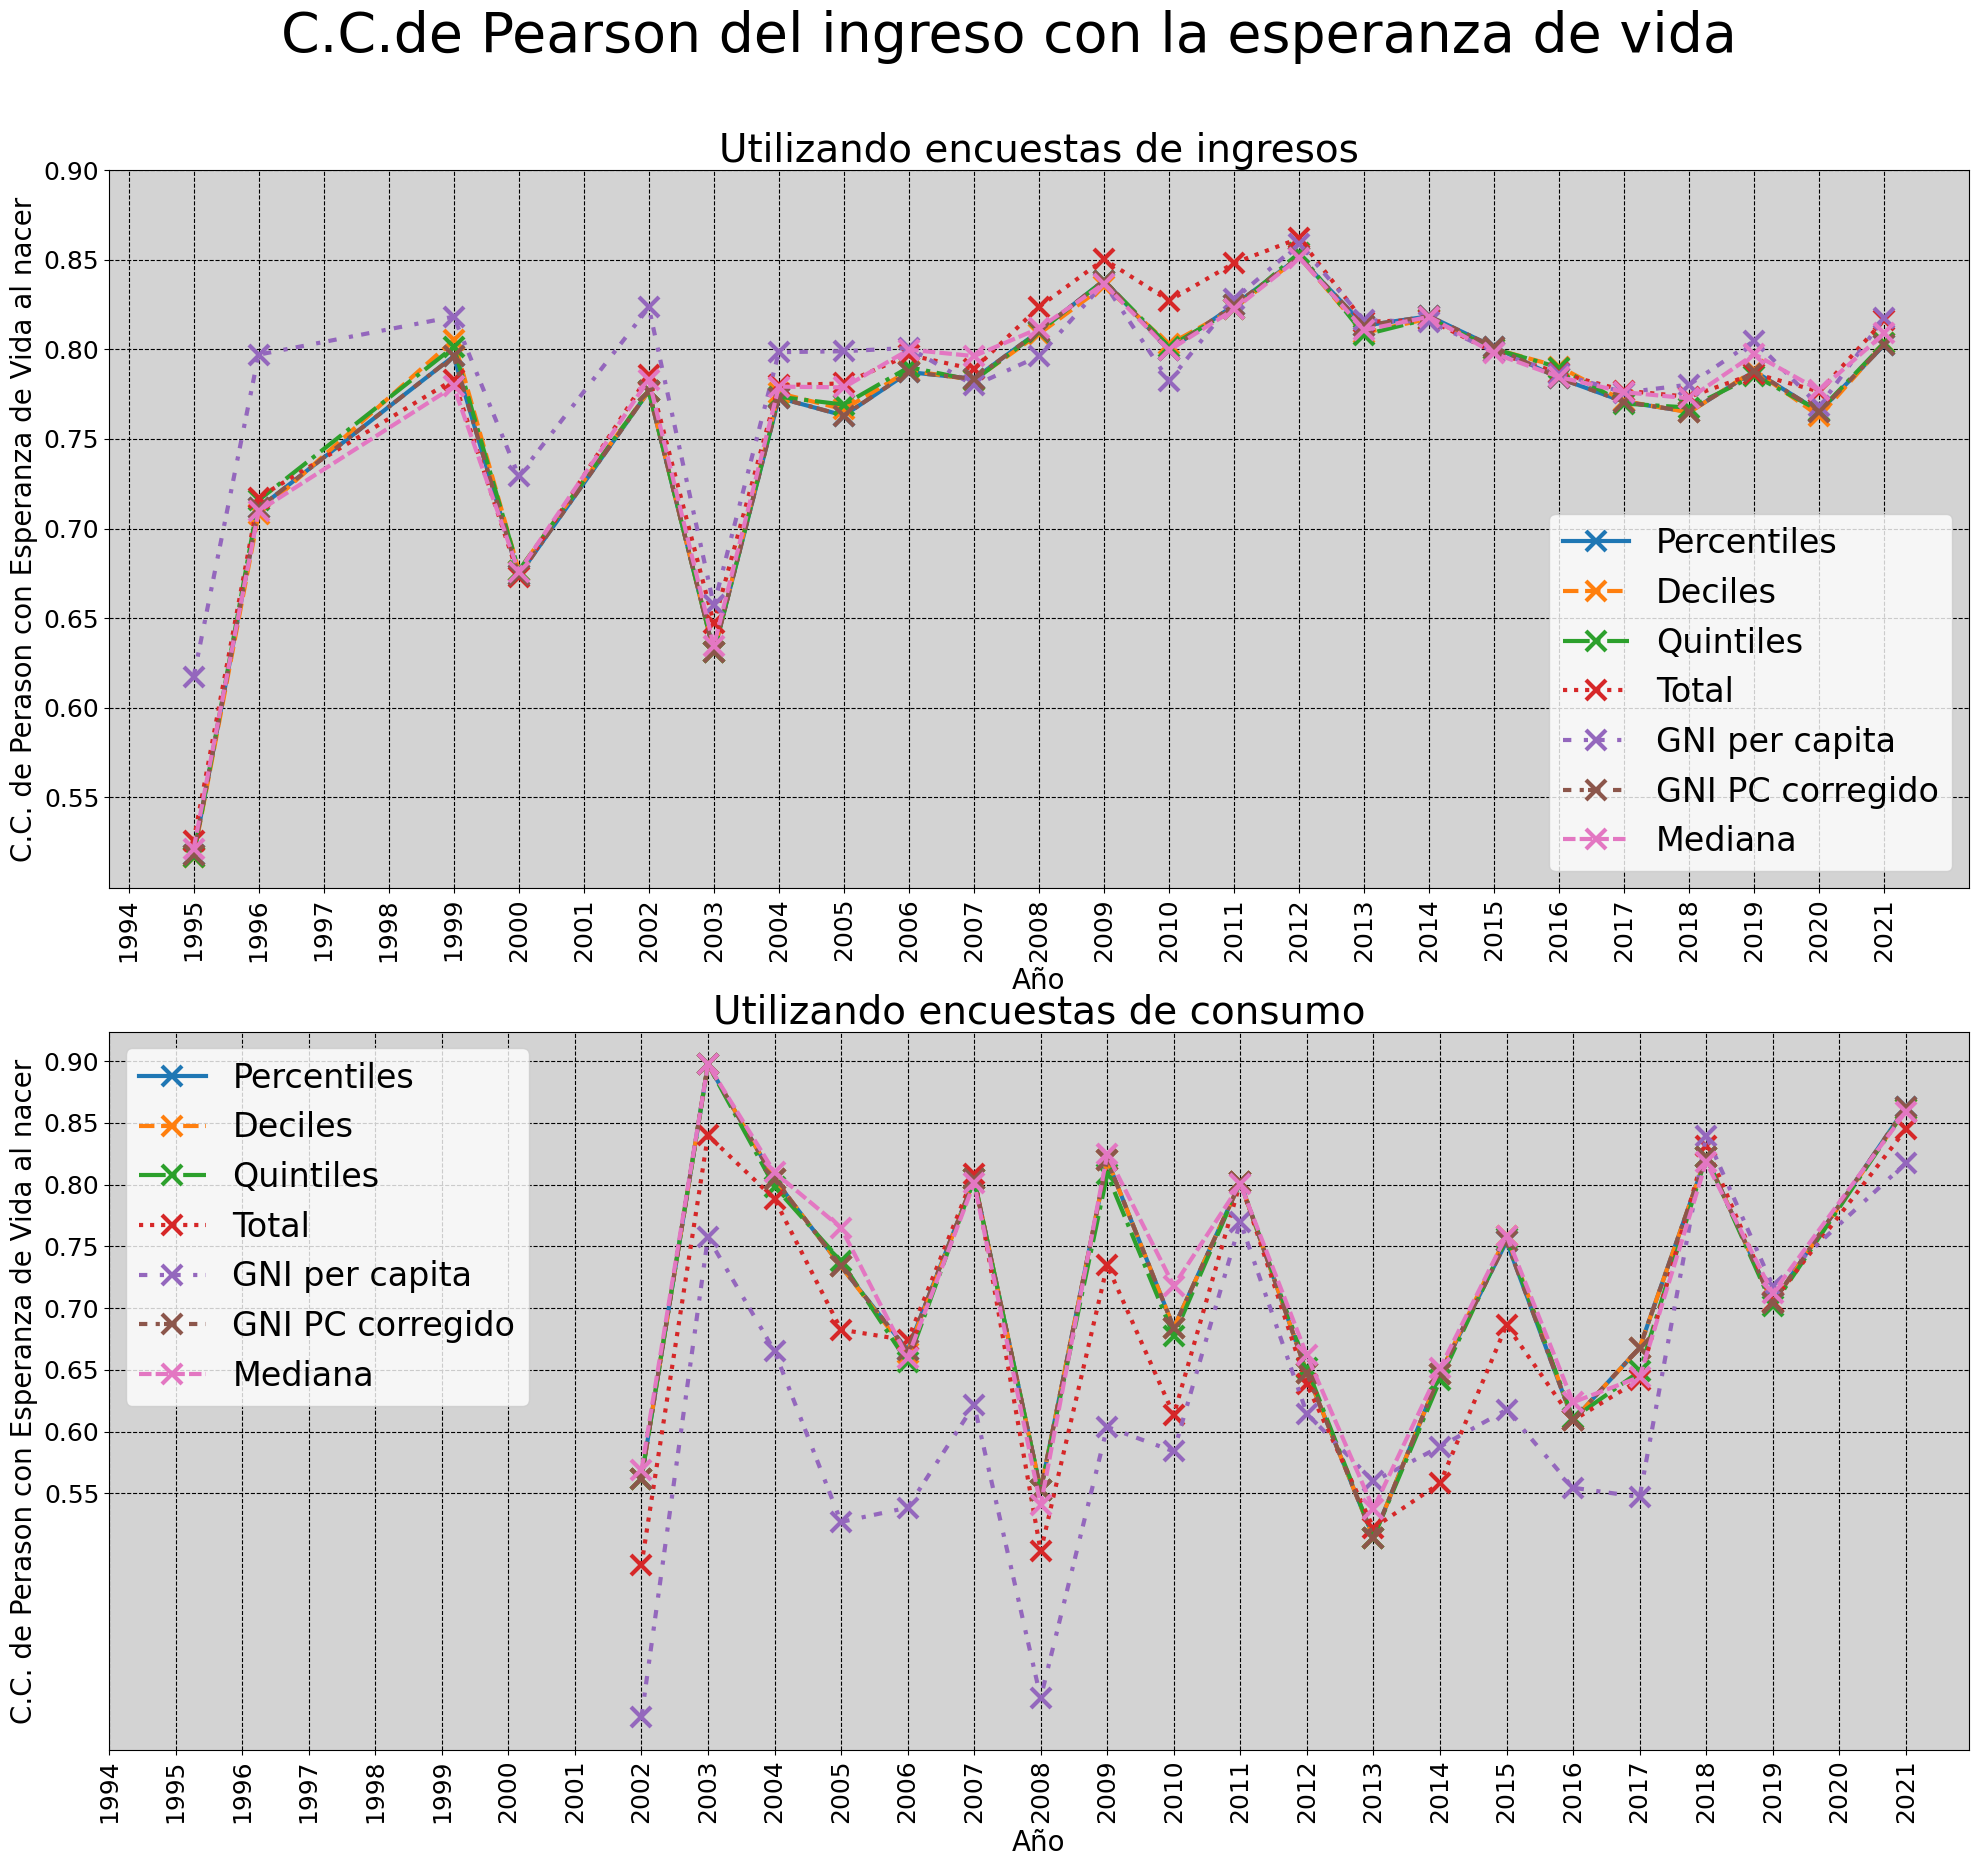

In [151]:
# from general import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

esperanza_vida = pd.read_csv("../datos reales/esperanza_vida.csv").drop("Series Code", axis=1)
def Cambiar(s : str):
    if s[-1]==']': return s[:4]
    return s

esperanza_vida.columns = list(map(Cambiar, esperanza_vida.columns))
esperanza_vida[esperanza_vida=='..'] = pd.NA

gni_ppa = pd.read_csv("../datos reales/gni_ppa_2021_per_capita.csv")
gni_ppa.columns = list(map(Cambiar, gni_ppa.columns))
gni_ppa[gni_ppa=='..'] = pd.NA


coltotal = esperanza_vida['Series Name'].unique()[2]
total = esperanza_vida[esperanza_vida['Series Name']==coltotal]

percentiles_ingresos = pd.read_csv("../datos reales/percentiles_ingresos_PPA_2011.csv")

def Sintetizador(tam = 100):
    def Sintesis(ingresos):
        sintesis = 0
        for ini in range(0,100,tam):
            rango = ingresos.iloc[ini:(ini+tam)]
            peso = np.sum(rango['pop_share'])
            avg_rango = np.sum(rango['avg_welfare'] * rango['pop_share'])/peso
            sintesis += np.log(avg_rango)*peso
        return sintesis
    return Sintesis

def GenerarMuestra(datos_originales, evida, umbral):
    muestras = dict()
    for year in sorted(datos_originales['year'].unique()):
        datos_anio = datos_originales[datos_originales['year']==year]
        paises = datos_anio['country_code'].unique()
        
        paises = list(filter(lambda x : 
            sum(datos_anio['country_code']==x)==100, paises
        ))
        esp_vida = evida[~ total[str(year)].isna()]
        paises = set(paises).intersection(esp_vida['Country Code'].unique())
        paises = list(paises) 

        gni = gni_ppa[~gni_ppa[str(year)].isna()]
        paises = set(paises).intersection(gni['Country Code'].unique())
        paises = list(paises) 
    
        if len(paises) < umbral: continue
        
        grupos_in = datos_anio.groupby('country_code')
        
        muestras[year] = []
        
        esp_vida.set_index('Country Code', inplace=True)
        gni.set_index('Country Code', inplace=True)

        for country in paises:
            tams = (1,10,20,100)
            muestra = []
            for (i,tam) in enumerate(tams):
                muestra.append(Sintetizador(tam)(grupos_in.get_group(country)))
            muestra.append(np.log(float(gni.loc[country][str(year)])))
            
            A = np.exp(muestra[0]-muestra[-1])
            muestra.append(np.log(float(gni.loc[country][str(year)]) * A))

            muestra.append(np.quantile(grupos_in.get_group(country)['avg_welfare'], q=0.5))
            muestras[year].append((country,muestra, esp_vida.loc[country][str(year)]))
    return muestras

percentiles_ingresos_ni = percentiles_ingresos[
    np.array(percentiles_ingresos['welfare_type']=='income') &
    np.array(percentiles_ingresos['reporting_level']=='national')
]

percentiles_ingresos_comp = percentiles_ingresos[
    np.array(percentiles_ingresos['welfare_type']=='consumption') &
    np.array(percentiles_ingresos['reporting_level']=='national')
]

muestras_ingreso = GenerarMuestra(percentiles_ingresos_ni,total,20)
muestras_consumo = GenerarMuestra(percentiles_ingresos_comp,total,20)

fig, axs = plt.subplots(2,1, figsize=(24,20))
fig.subplots_adjust(top=0.90) 
fig.suptitle('C.C.de Pearson del ingreso con la esperanza de vida', fontsize=40)

muestras = [muestras_ingreso, muestras_consumo]
nombres_m = ["ingresos","consumo"]
nombres =  ["Percentiles","Deciles","Quintiles","Total", "GNI per capita", "GNI PC corregido", "Mediana"]
estilos =  ['-','--','-.',':', (0,(2,3,1,2)), (0,(2,2,1,1,3,3)), (0,(3,1))]

xticks = list(range(1994,2022))
xlabel_ticks = list(map(str, xticks))

yticks_mayor = np.linspace(0.55,0.9,8)
yticks_menor = np.linspace(0.55,0.9,15)

def GenerarSeries(muestras, metrica):
    xs = list(sorted(muestras.keys()))
    ys = []
    for x in xs:
        muestra = muestras[x]
        series = []
        for i in range(len(muestra[0][1])):
            a = [float(item[1][i]) for item in muestra]
            b = [float(item[2]) for item in muestra]
            series.append(metrica(a,b))
        ys.append(tuple(series))
    return xs,ys

for (ax,muestra,nombre_muestra) in zip(axs,muestras,nombres_m):
    xs, ys = GenerarSeries(muestra, lambda x,y : spearmanr(x,y).correlation)
    for (i, nombre, estilo) in zip(range(len(nombres)),nombres,estilos):
        ax.plot(xs,[y[i] for y in ys], label = nombre, linestyle=estilo, marker='x', linewidth=3, markersize = 15, markeredgewidth=3)
    
    ax.set_ylabel("C.C. de Perason con Esperanza de Vida al nacer", fontsize=20)
    ax.set_xlabel("Año", fontsize=20)
    ax.set_title(f"Utilizando encuestas de {nombre_muestra}", fontsize = 28)
    ax.set_xticks(ticks = xticks, labels= xlabel_ticks, rotation=90, fontsize=18)
    # ax.set_xticks(ticks = xticks, labels=[None]*len(xticks))
    ax.set_yticks(ticks = yticks_mayor, minor=False, labels=list(map(lambda x: f"{x:.2f}", yticks_mayor)), fontsize=18)
    # ax.set_yticks(ticks = yticks_menor, labels=("" for _ in yticks_menor), linestyle=(0,(2,1)), minor=True)
    ax.grid(c='black', linestyle='--')
    ax.set_facecolor('lightgray')
    ax.legend(fontsize=24)


# fig.savefig("../figuras/figura_19_empirico_todas_metricas_vs_evn_pearson.png",bbox_inches='tight')